In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

import ipywidgets as widget

%matplotlib inline


# Problem Definition

The goal of this project is to predict customer churn for an internet service provider using a dataset of customer characteristics. Customer churn is the number of customers that have cancelled their subscription in a given time period. This is a binary classification problem that will classify a customer as either likely to cancel or not cancel their subscription.

# Dataset

The dataset used for this project is called Internet Service Provider Customer Churn and is located at Kaggle.com

https://www.kaggle.com/datasets/mehmetsabrikunt/internet-service-churn

# Evaluation

The project will be pursued further if the model can predict customer churn with at least 90% accuracy.

# Data Features

Below is a data dictionary that gives information about each feature of the dataset.

1. "id" - This is a unique customer id; it is not used to train the model.   
2. "is_tv_subscriber" - 1 means the customer has a tv subscription and 0 means they do not have a subscription.  
3. "is_movie_package_subscriber" - 1 means the customer has a movie package subscription and 0 means they do not.  
4. "subscription_age" - A float value that is the age of the customer's account in years.  
5. "bill_avg" - A float value that is the customer's average bill over the past three months.  
6. "remaining_contract" - 1 means the customer has a contract with the company and 0 means they do not.  
7. "service_failure_count" - An integer value that is the number of times the customer's service failed over the past three months.  
8. "download_avg" - A float value that is the customer's average download speed (in GB) over the last three months.  
9. "upload_avg" - A float value that is the customer's average upload speed (in GB) over the last three months.  
10. "download_over_limit" - An integer value that is the number of times the customer went over their download limit over the past three months.  
11. "churn" - This is the target column; 1 means the customer cancelled their service, 0 means that they haven't cancelled.  

In [2]:
data = pd.read_csv("internet_service_churn.csv")
data_temp = data.copy()

# Data Transformation

In order to use the data to train the model it will be necessary to fill or remove any rows with missing values.

In [3]:
# This shows the number of missing values in the data.
data_temp.isna().sum()

id                                 0
is_tv_subscriber                   0
is_movie_package_subscriber        0
subscription_age                   0
bill_avg                           0
remaining_contract             21572
service_failure_count              0
download_avg                     381
upload_avg                       381
download_over_limit                0
churn                              0
dtype: int64

In [4]:
# This will replace any missing values in the remaining_contract column with 0.
data_temp["remaining_contract"].fillna(0, inplace=True)
data_temp.loc[data_temp["remaining_contract"] != 0, "remaining_contract"] = 1

In [5]:
# This will drop the rows containing missing values in the download average and upload average columns.
data_temp.dropna(subset=["download_avg"], inplace=True)
data_temp.dropna(subset=["upload_avg"], inplace=True)

In [6]:
# This will drop the id column that isn't used to train or test the machine learning algorithm.
data_temp.drop(labels=["id"], axis=1, inplace=True)

In [7]:
# Now the data contains no missing values and is reading for training and testing.
data_temp.isna().sum()

is_tv_subscriber               0
is_movie_package_subscriber    0
subscription_age               0
bill_avg                       0
remaining_contract             0
service_failure_count          0
download_avg                   0
upload_avg                     0
download_over_limit            0
churn                          0
dtype: int64

# Data Visualization

The dataset contains over 70,000 rows so it is helpful to use data visualization techniques to help identify trends in the data.

### How does a customer having a tv or movie package subscription effect the churn rate?

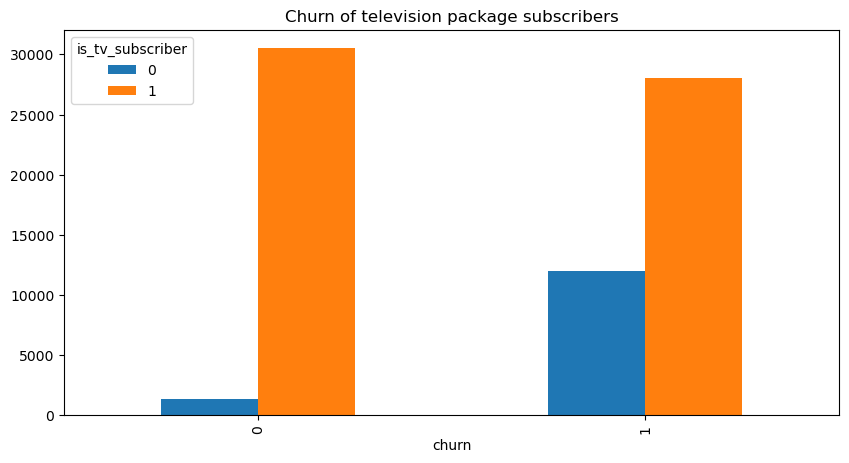

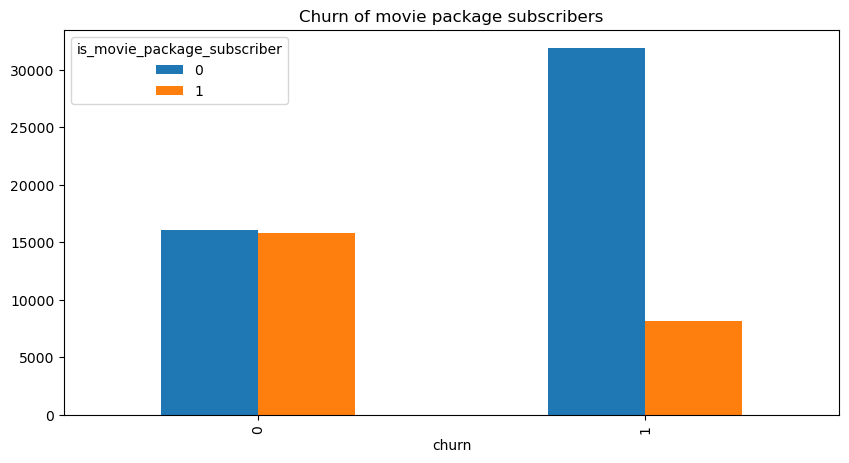

In [8]:

pd.crosstab(data_temp["churn"], data_temp["is_tv_subscriber"]).plot(kind="bar",
                                                                    title="Churn of television package subscribers",
                                                                   figsize=(10,5));
pd.crosstab(data_temp["churn"], data_temp["is_movie_package_subscriber"]).plot(kind="bar",
                                                                               title="Churn of movie package subscribers",
                                                                              figsize=(10,5));


#### These two graphs compare the churn rate for customers based on whether or not they have a tv or movie package subscription. The graphs seem to suggest that the churn rate is similar for a customer regardless of if they had a tv subscription or not. The graphs also suggest that a movie package subscription may be important for customer retention as the churn rate for customer with a movie subscription is lower than for customers without one.

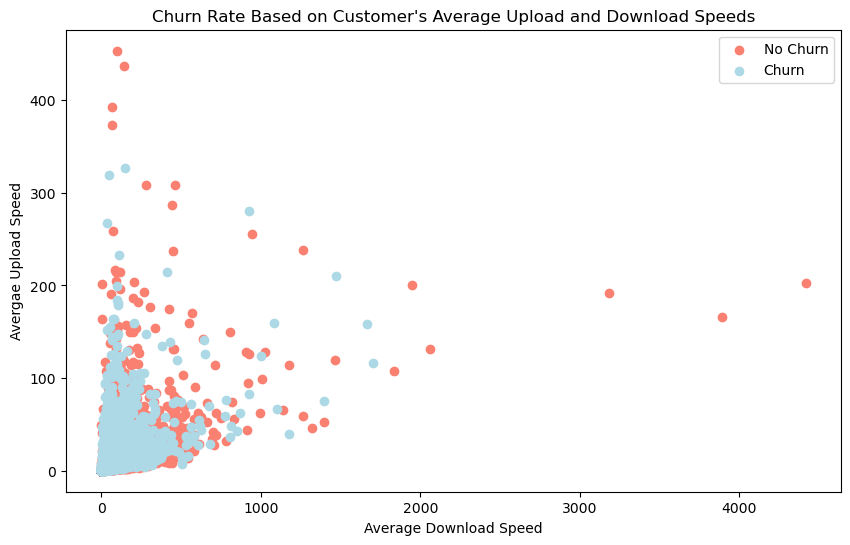

In [9]:
plt.figure(figsize=(10,6))

plt.scatter(data_temp["download_avg"][data_temp["churn"]==0],
                                      data_temp["upload_avg"][data_temp["churn"]==0],
           c = "salmon");

plt.scatter(data_temp["download_avg"][data_temp["churn"]==1],
                                      data_temp["upload_avg"][data_temp["churn"]==1],
           c = "lightblue")
plt.title("Churn Rate Based on Customer's Average Upload and Download Speeds")
plt.xlabel("Average Download Speed")
plt.ylabel("Avergae Upload Speed")
plt.legend(["No Churn", "Churn"]);


#### This scatter chart compares a customer's average upload and download speed and whether they cancelled their subscription.  Typical internet subscriptions have higher download than upload speeds but usually paying for an increase in one results in an increase in the other. The scatter graph doesn't show much of a trend in the data suggesting the customer's download and upload speeds doesn't affect the churn rate. 

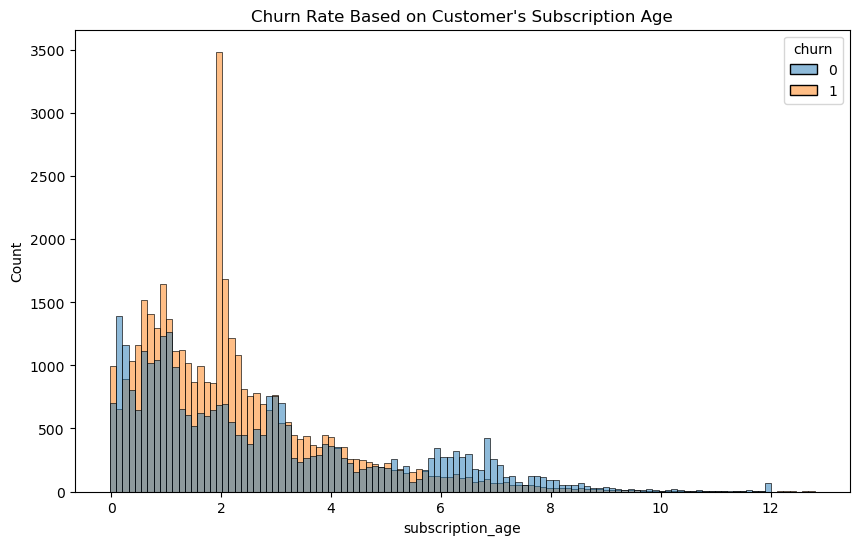

In [10]:
plt.figure(figsize=(10,6))

sns.histplot(data=data_temp, x="subscription_age", hue="churn")

plt.title("Churn Rate Based on Customer's Subscription Age");

#### This histogram shows the churn rate for customer's subscriptions compared to the customer's account age. The trend appears to be that newer accounts are more likely to churn.

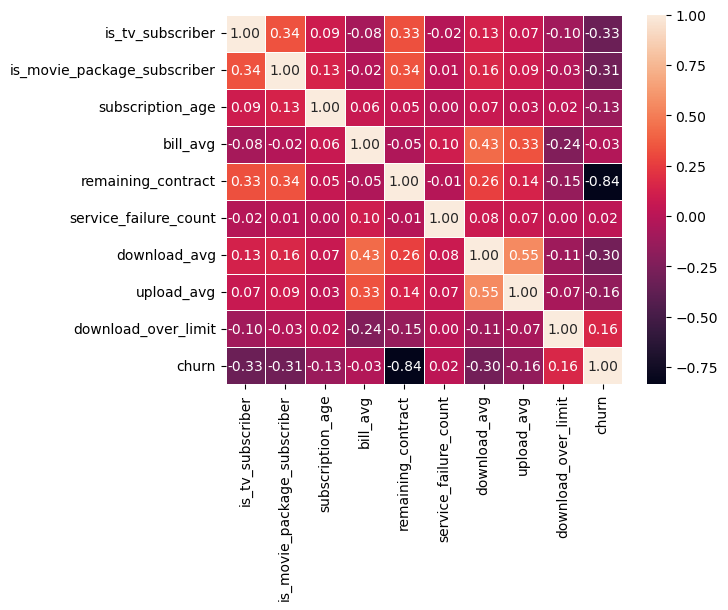

In [11]:
cm = data_temp.corr()
sns.heatmap(cm,
           annot=True,
           linewidth=0.5,
           fmt= "0.2f");

#### This heatmap shows the correlation between the features and how they may influence the dependent variable (customer churn). The heat map shows the features with the greatest correlation with churn are the number of service failures and the number of times over the download limit.

# Model Training and Testing

#### There are many different machine learning algorithms for classification problems whose performance can vary depending on the size of the dataset, the kind of data (text versus numeric), and if the data is labeled or not.  For the classification problem addressed in this project, three potential algorithms will be compared; the random forest classifier, the k nearest neighbors classifier, and the decision tree classifier. Which ever model has the highest accuracy score will be used in the application to allow users to make predictions about customer churn. 

In [12]:
# Split the data into x and y sets; x contains the independent features to train the model and y contains the features
# we are trying to predict

x = data_temp.drop(labels=["churn"], axis=1).values
y = data_temp["churn"].values

In [13]:
# Use the x and y datasets to create training and test splits.

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)


In [14]:
# Create instances of the models and train them.
np.random.seed(42)

rfc = RandomForestClassifier()
knn = KNeighborsClassifier()
dtc = DecisionTreeClassifier()

rfc.fit(x_train, y_train)
knn.fit(x_train, y_train)
dtc.fit(x_train, y_train)

DecisionTreeClassifier()

In [15]:
# Compare the accuracy scores of the models.

model_scores = {"rfc": rfc.score(x_test, y_test),
               "knn": knn.score(x_test, y_test),
               "dtc": dtc.score(x_test, y_test)
               }

model_scores

{'rfc': 0.9398428263439739,
 'knn': 0.8469295500382502,
 'dtc': 0.9006885040684331}

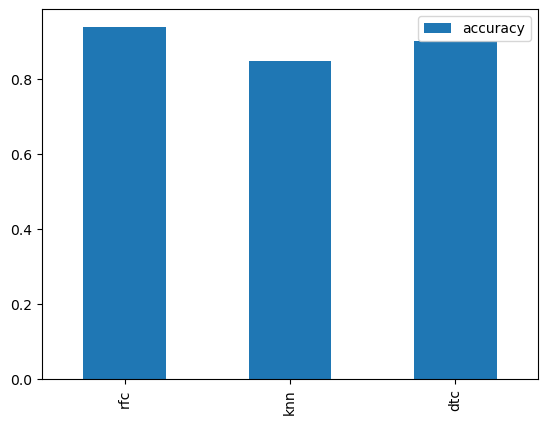

In [16]:
# Plot the model scores to help visualize the results.
pd.DataFrame(model_scores, index=["accuracy"]).T.plot(kind="bar");

In [17]:
forest_importances = pd.Series(rfc.feature_importances_, index=data_temp.columns.drop([ "churn"]))

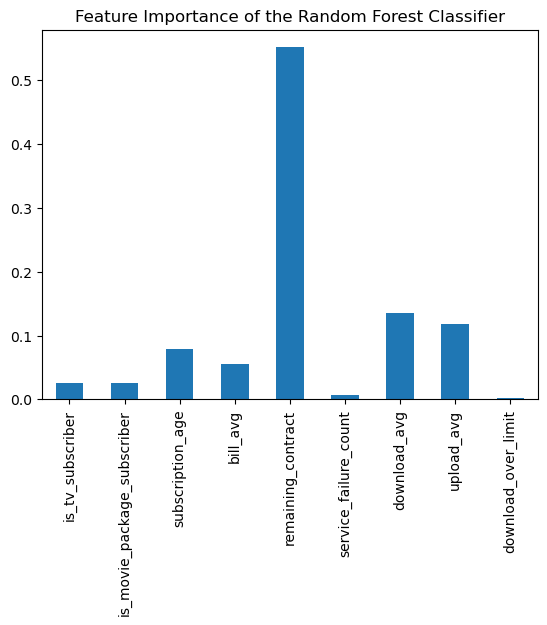

In [18]:
fig, ax = plt.subplots()
forest_importances.plot.bar()
ax.set_title("Feature Importance of the Random Forest Classifier");

#### This shows that the most important feature to the model's prediction is whether or not the customer has a contract with the company.

# Use the Model to Make Predictions

#### The Random Forest Classifier model was the most accurate so it will be chosen to used in the application to make predictions about customer churn.

In [19]:
# These are the functions that enable the function to return a prediction. The return_prediction function takes the users 
# choices inputted to the appliaction and uses them as the parameters for the model to make a precition. The button_clicked
# function calls the return_prediction function when pressed by the user and their inputted values are used to make a 
# prediction that is outputted to the UI so the user can view it.

def button_clicked(b):
    with output:
        output.clear_output()
        print(" ")
        print(return_prediction(model=rfc, a=tv_sub.value, b=movie_sub.value, c=sub_age.value, d=bill_avg.value,
                                         e=remain_cont.value, f=serv_fail.value, g=down_avg.value, h=up_avg.value,
                                         i=over_limit.value))
        
def return_prediction(model, a, b, c, d, e, f, g, h, i):
    
    items = [[a,b,c,d,e,f,g,h,i]]
    predict = model.predict(items)
        
    if predict[0] == 1:
        return "This customer is likely to cancel their subscription"
    else:
        return "This customer is unlikely to cancel their subscription."

In [20]:
# This code sets up each input widget and places them in a vertical box with a submit button.

style = {'description_width': '150px'}
layout = {'width': 'auto'}

tv_sub = widget.Checkbox(
    value=False,
    description='Tv Subscriber',
    disabled=False,
    style = style,
    indent=False)

movie_sub = widget.Checkbox(
    Value=False,
    description = "Movie Subscriber",
    style = style,
    disabled=False,
    indent=False)

sub_age = widget.BoundedFloatText(
    value=0,
    min = 0,
    description="Subscription Age",
    style = style,
    disabled=False)

bill_avg = widget.BoundedFloatText(
    value=0,
    min = 0,
    description = "Bill Average",
    style = style,
    disabled=False)

remain_cont = widget.Checkbox(
    value=False,
    description="Remaining Contract",
    disabled=False,
    style = style,
    indent=False)

serv_fail = widget.BoundedIntText(
    value=0,
    min = 0,
    description="Service Failure Count",
    style = style,
    disabled=False
)

down_avg = widget.BoundedFloatText(
    value=0,
    min=0,
    description="Download Average",
    style = style,
    disabled=False)

up_avg = widget.BoundedFloatText(
    value=0,
    min=0,
    description="Upload Average",
    style=style,
    disabled=False)

over_limit = widget.BoundedIntText(
    value=0,
    min=0,
    description="Download Over Limit",
    disabled=False,
    style = style)

submit_button = widget.Button(description="Predict Churn")
output = widget.Output()
title = widget.HTML(value="<h2>Customer Churn Prediction Application</h2>")
submit_button.on_click(button_clicked)

vbox0 = widget.VBox([title, sub_age, bill_avg, serv_fail, down_avg, up_avg, over_limit, tv_sub, movie_sub, remain_cont, 
                     submit_button, output])

In [21]:
# This cell displays the application interface. Input the customer's information and press predict churn to see the
# prediction regarding the likelyhood of customer churn.
display(vbox0)